In [1]:
from scipy.integrate import odeint
import numpy as np
import theano 
import theano.tensor as tt
import scipy
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'

In [2]:
def f(y, t, theta):
    """"This is the ODE system.
    
    The function can act on either numpy arrays or theano TensorVariables
    
    Args:
        y (vector): system state
        t (float): current time (optional)
        theta (vector): parameters of the ODEs
        
    Returns:
        dydt (list): result of the ODEs
    """
    return [
        -theta*y[0]*y[1],   #= dS/dt
        theta*y[0]*y[1] - y[1] #= dI/dt
            ]

In [3]:
n_states = 2
n_odeparams = 1
n_ivs = 2

class ODEModel(object):
    
    def __init__(self, odefunc, n_states, n_odeparams, n_ivs, y0):
        
        self.odefunc = odefunc
        self._n_states = n_states
        self._n_odeparams = n_odeparams
        self._n_ivs = n_ivs
        self._y0 = y0
        
        self.system = self._create_system()
        
    def _create_system(self):
        #Define the differential Equation

        #Present state of the system
        y = tt.dvector('y')
        #Parameter
        #TODO:  Allow for multiple parameters.  Maybe let this be a vector?
        p = tt.dscalar('p')
        #Present state of the gradients: will always be 0 unless the parameter is the inital condition
        dydp = tt.dvector('dydp')

        f_tensor = tt.stack(self.odefunc(y, None, p))

        #Now compute gradients
        #Use Rop to compute the Jacobian vector product
        Jdfdy = tt.Rop(f_tensor, y, dydp)

        grad_f = tt.jacobian(f_tensor, p)
        #This is the time derivative of dydp
        ddt_dydp = Jdfdy + grad_f


        #Compile the system as a theano function
        #Args:
            #y - array of length 2 representing current state of the system (S and I)
            #dydp - array of length 2 representing current state of the gradient (dS/dp and dI/dp)
        system = theano.function(
            inputs=[y, dydp, p],
            outputs=[f_tensor, ddt_dydp])
        
        return system
    
    def odesys(self,Y,t,p):

        """
        This is the function that wull be passed to odeint.
        Solves both ODE and sensitivities
        
        Args:
            Y (vector): current state and current gradient state
            t (scalar): current time
            p (vector): parameters

        Returns:
            derivatives (vector): derivatives of state and gradient
        """
        dydt, dydp = self.system(Y[:2], Y[2:], p)
        return np.concatenate([dydt, dydp])
    
    def simulate(self, parameters, times):
        
        return scipy.integrate.odeint(func = self.odesys, t = times, y0 = self._y0, args = tuple(parameters))
        

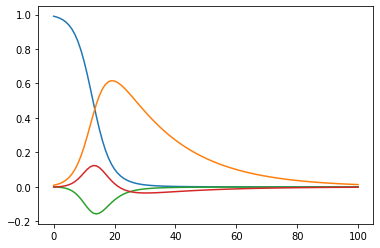

In [4]:
ode_model = ODEModel( odefunc = f, n_states = 2, n_odeparams = 1, n_ivs = 2, y0 = [0.99,0.01, 0,0])
sims = ode_model.simulate(parameters = [8], times = np.linspace(0,5,101) )

plt.plot(sims)


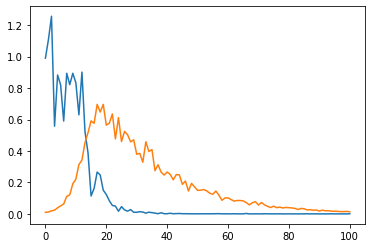

In [5]:
#Create data to learn from
S = scipy.stats.lognorm.rvs(s = 0.5, scale = sims[:,0])
I = scipy.stats.lognorm.rvs(s = 0.1, scale = sims[:,1])
S[0] = 0.99
I[0] = 0.01
plt.plot(S)
plt.plot(I)


In [6]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
      
        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            sol = ode_model.simulate(x, times)
            state = sol[:,:2]
            sens = sol[:,2:]
        
        return state,sens
    
times = np.linspace(0,5,101)
cached_solver=solveCached(times, n_odeparams + n_ivs, n_states)

In [7]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.reshape((2*len(State),))

def numpy_vsp(x, g):    
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

In [8]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)       # get the numerical VSP
        

In [9]:
class ODEop(theano.Op):

    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = self._state(x)               # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient 
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]

In [10]:
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'


# Define the data matrix
Y = np.vstack((S,I)).T

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)

# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    
    
    
    p = pm.Normal('R0', mu = 6, sd = 0.5)
    
    sigma = pm.Lognormal('sigma', mu=-1, sd=1, shape=2)

    # Forward model
    all_params = pm.math.stack([p],axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(1500, tune=1000, init='adapt_diag')
trace['diverging'].sum()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, R0]
Sampling 4 chains: 100%|██████████| 10000/10000 [03:59<00:00, 41.77draws/s]


0

In [11]:
pm.gelman_rubin(trace)

{'R0': 0.9999898972348045, 'sigma': array([0.99973309, 1.00006585])}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c26216ef0>,
      dtype=object)

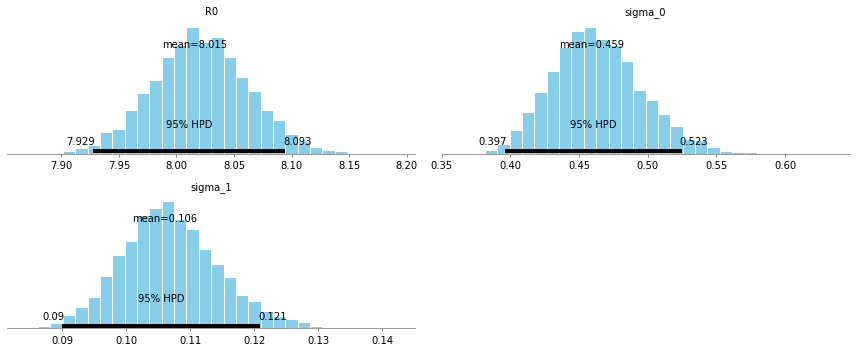

In [12]:
pm.posteriorplot.plot_posterior(trace)

In [13]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=500, model=LV_model)['Y_obs']


AttributeError: module 'pymc3' has no attribute 'sample_posterior_predictive'

In [ ]:
for i in range(100):
    ppc = ppc_samples[i]
    plt.plot(ppc[:,0], alpha = 0.1, color = 'C0')
    plt.plot(ppc[:,1], alpha = 0.1, color = 'C1')